# Simple Refridgeration Cycle

Alex Dowling, University of Notre Dame

Thank you ChatGPT!

## Import and Configure Thermodynamics

In [1]:
# Import required IDAES-PSE modules
from idaes.core import FlowsheetBlock
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
)
from idaes.models.unit_models import (Heater, Turbine, Compressor, 
                                      Mixer, Separator, PressureChanger)
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors
from pyomo.environ import ConcreteModel, value, Objective, SolverFactory
from idaes.core.util.initialization import propagate_state
from pyomo.network import Arc
from pyomo.environ import units as pyunits
import numpy as np
import matplotlib.pyplot as plt

# Create the ConcreteModel and Flowsheet
model = ConcreteModel()
model.fs = FlowsheetBlock(dynamic=False)

# Add property package for a common refrigerant (e.g., R134a) using General Helmholtz model
model.fs.properties = HelmholtzParameterBlock(pure_component="R134a", state_vars=StateVars.TPX)

## Generate Diagrams from Thermodynamics Package

Ideas for next steps:
1. Change state variables to PH as recommended here: https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/property_models/helmholtz.html
2. Using the PH diagram below, guess some reasonable initial points
   - https://www.engproguides.com/pressure-enthalpy-diagram.html#:~:text=The%20left%20vertical%20curve%20indicates,indicates%20the%20saturated%20vapor%20curve.
   - https://www.researchgate.net/figure/Simple-vapour-compression-refrigeration-cycle-on-P-h-diagram_fig1_346765777
3. Initialize the flowsheet
4. Fix the temperatures as desired

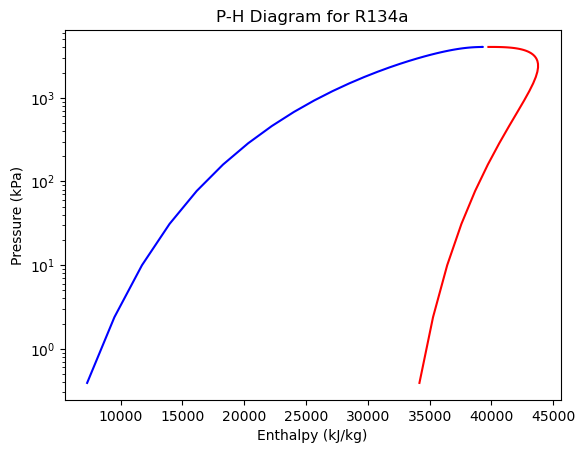

In [2]:
model.fs.properties.hp_diagram()
plt.show()

In [13]:
from pyomo.environ import units
import pandas as pd

# Set operating conditions
high_pressure = ((85 - 32) * 5/9 + 273.15)*units.K  # Convert 130 F to Kelvin
low_pressure = ((65 - 32) * 5/9 + 273.15)*units.K   # Convert 50 F to Kelvin


points = ['A', 'B', 'C', 'D']
T = [high_pressure, low_pressure, low_pressure, high_pressure]
x = [0, 0, 1, 1]
h = np.zeros(len(points))
s = np.zeros(len(points))

for i, p in enumerate(points):
    h[i] = model.fs.properties.htpx(T=T[i], x = x[i])
    s[i] = model.fs.properties.stpx(T=T[i], x = x[i])

data = {
    'Point': points,
    'Temperature (K)': [value(temp) for temp in T],
    'Vapor Fraction': x,
    'Enthalpy (J/mol)': h,
    'Entropy (J/mol.K)': s
}

df = pd.DataFrame(data)
df.head()


Point  Temperature (K)  Vapor Fraction  Enthalpy (J/mol)  Entropy (J/mol.K)
0     A       302.594444               0      24581.534478         116.406733
1     B       291.483333               0      22970.352851         111.043511
2     C       291.483333               1      41717.416404         175.359585
3     D       302.594444               1      42297.144931         174.952456

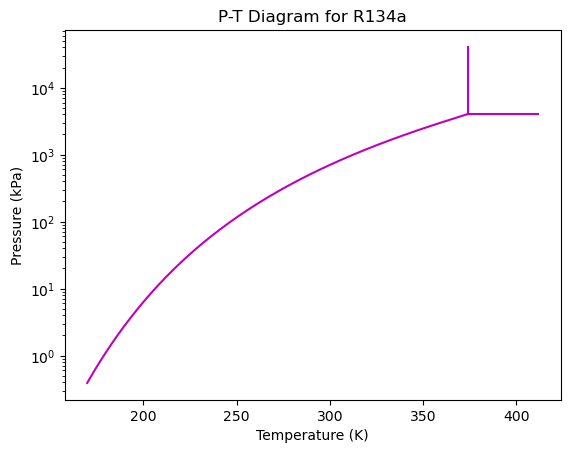

In [15]:
model.fs.properties.pt_diagram()
plt.show()

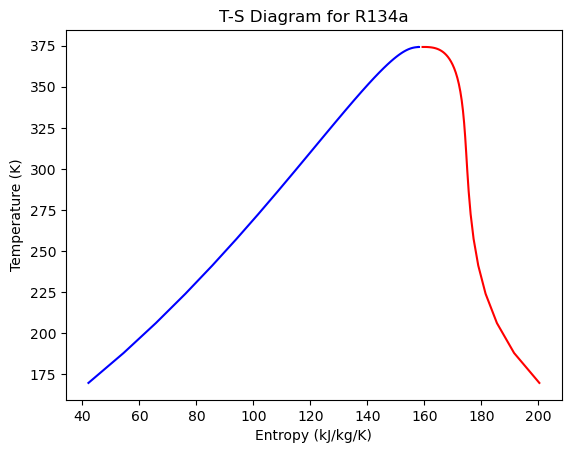

In [ ]:
model.fs.properties.st_diagram()
plt.show()

## Simple Flowsheet

Challenge: Initialization is failing to convergence, possibly too few degrees of freedom for some units.

Ideas:
- Switch to alternate state representation
- Use helper functions for enthalpy and entropy to compute initial points
- Determine reasonable initial points from the phase diagrams/thermodynamic charts
- Attempt to simulate each unit operation is isolation first

Eventual enhancements:
- Plot streams from simple cycle on the three thermodyanmic charts
- Use more sophisticated thermodynamic assumption for compressor

In [ ]:
import logging
# Set up logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Add unit models to the flowsheet
model.fs.evaporator = Heater(property_package=model.fs.properties)
model.fs.compressor = Compressor(property_package=model.fs.properties)
model.fs.condenser = Heater(property_package=model.fs.properties)
model.fs.expansion_valve = PressureChanger(property_package=model.fs.properties, 
                                           thermodynamic_assumption="isentropic")

# Connect components with arcs
model.fs.evaporator_to_compressor = Arc(source=model.fs.evaporator.outlet, 
                                        destination=model.fs.compressor.inlet)
model.fs.compressor_to_condenser = Arc(source=model.fs.compressor.outlet, 
                                       destination=model.fs.condenser.inlet)
model.fs.condenser_to_expansion_valve = Arc(source=model.fs.condenser.outlet, 
                                            destination=model.fs.expansion_valve.inlet)
model.fs.expansion_valve_to_evaporator = Arc(source=model.fs.expansion_valve.outlet, 
                                             destination=model.fs.evaporator.inlet)

# Expand arcs to build the connectivity
#from idaes.core.util import model_serializer as ms
# expand_arcs(model.fs.evaporator_to_compressor)

from pyomo.environ import TransformationFactory
TransformationFactory('network.expand_arcs').apply_to(model)

# Deactivate the flowrate constraint on one of the arcs
model.fs.evaporator_to_compressor_expanded.flow_mol_equality.deactivate()



print("Outside temperature:", outside_temp, "K")
print("Indoor temperature:", indoor_temp, "K")

delta_T_evaporator = 5  # Evaporator temperature difference

# Evaporator (low-pressure side)
model.fs.evaporator.inlet.flow_mol[0].fix(100)   # Example value
#model.fs.evaporator.outlet.temperature[0].fix(indoor_temp - delta_T_evaporator)
model.fs.evaporator.outlet.vapor_frac[0].fix(1.0)  # Ensure vapor phase

# Compressor (compressing the vapor)
model.fs.compressor.outlet.vapor_frac[0].fix(1.0)  # Ensure the outlet is vapor

# Condenser (high-pressure side)
model.fs.condenser.outlet.temperature[0].fix(outside_temp)
model.fs.condenser.outlet.vapor_frac[0].fix(0.0)  # Ensure the outlet is liquid

# Expansion Valve
# No pressure fix here, the outlet phase constraints handle the operation

# Set up scaling and check degrees of freedom
calculate_scaling_factors(model)
# assert degrees_of_freedom(model) == 0

# Initialize the unit operations sequentially with logging
try:
    logger.info("Initializing evaporator...")
    model.fs.evaporator.initialize(outlvl=logging.DEBUG)
    propagate_state(model.fs.evaporator_to_compressor)
    
    logger.info("Initializing compressor...")
    model.fs.compressor.initialize(outlvl=logging.DEBUG)
    propagate_state(model.fs.compressor_to_condenser)
    
    logger.info("Initializing condenser...")
    model.fs.condenser.initialize(outlvl=logging.DEBUG)
    propagate_state(model.fs.condenser_to_expansion_valve)
    
    logger.info("Initializing expansion valve...")
    model.fs.expansion_valve.initialize(outlvl=logging.DEBUG)
    propagate_state(model.fs.expansion_valve_to_evaporator)
except Exception as e:
    logger.error(f"Initialization failed: {e}")
    raise

# Add objective function to maximize the coefficient of performance (COP)
model.fs.COP = Objective(expr=(model.fs.evaporator.outlet.flow_mol[0] * 
                               (model.fs.evaporator.outlet.temperature[0] - model.fs.evaporator.inlet.temperature[0])) /
                         (model.fs.compressor.work_mechanical[0]), sense=1)


# Solver setup
solver = get_solver()

# Solve the model
results = solver.solve(model, tee=True)

# Print results
if results.solver.termination_condition == 'optimal':
    print("Refrigeration cycle solved successfully.")
    print("Coefficient of Performance (COP):", value(model.fs.COP))
    print("Evaporator outlet temperature:", value(model.fs.evaporator.outlet.temperature[0]))
    print("Compressor outlet phase:", model.fs.compressor.outlet.phase[0].value)
    print("Condenser outlet temperature:", value(model.fs.condenser.outlet.temperature[0]))
    print("Condenser outlet phase:", model.fs.condenser.outlet.phase[0].value)
else:
    print("Refrigeration cycle did not converge.")


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
DEBUG:pyomo.core:Constructing _ScalarHeater 'evaporator' on Block 'fs' from data=None
DEBUG:pyomo.core:Constructing _ScalarHeater 'fs.evaporator', from data=None
DEBUG:pyomo.core:Constructing _ScalarControlVolume0DBlock 'control_volume' on Block 'fs.evaporator' from data=None
DEBUG:pyomo.core:Constructing _ScalarControlVolume0DBlock 'fs.evaporator.control_volume', from data=None
DEBUG:pyomo.core:Constructed component 'Block 'fs.evaporator.control_volume'':
control_volume : Size=1, Index=None, Active=True
    0 Declarations: 

DEBUG:pyomo.core:Constructing _IndexedHelmholtzStateBlock 'properties_in' on Block 'fs.evaporator.control_volume' from data=None
DEBUG:pyomo.core:Constructing _IndexedHelmholtzStateBlock 'fs.evaporator.control_volume.properties_in', from data=None
DEBUG:pyomo.core:Constructing IndexedExpression 'mole_frac_comp' on Block 'fs.evaporator.contro

Outside temperature: 302.59444444444443 K
Indoor temperature: 291.4833333333333 K
2025-03-06 21:38:24 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.evaporator.control_volume.heat


DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'


2025-03-06 21:38:24 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.compressor.control_volume.work


DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'


2025-03-06 21:38:24 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.condenser.control_volume.heat


DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'


2025-03-06 21:38:24 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.expansion_valve.control_volume.work


DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
DEBUG:pyomo.core:Constructing Suffix 'Suffix'
INFO:__main__:Initializing evaporator...


2025-03-06 21:38:24 [INFO] idaes.init.fs.evaporator.control_volume: Initialization Complete
2025-03-06 21:38:24 [INFO] idaes.init.fs.evaporator: Initialization Step 1 Complete.


DEBUG:pyomo.repn.plugins.nl_writer:Skipped component keys:
	fs.evaporator.control_volume.properties_in[0.0].eq_sat
	fs.evaporator.control_volume.properties_in[0.0].flow_mol
	fs.evaporator.control_volume.properties_in[0.0].pressure
	fs.evaporator.control_volume.properties_in[0.0].temperature
	fs.evaporator.control_volume.properties_in[0.0].vapor_frac
	fs.evaporator.control_volume.properties_out[0.0].eq_sat
	fs.evaporator.control_volume.properties_out[0.0].vapor_frac
DEBUG:pyomo.repn.plugins.nl_writer:Skipped component keys:
	fs.evaporator.control_volume.properties_in[0.0].cp_mass
	fs.evaporator.control_volume.properties_in[0.0].cp_mass_phase[Liq]
	fs.evaporator.control_volume.properties_in[0.0].cp_mass_phase[Vap]
	fs.evaporator.control_volume.properties_in[0.0].cp_mol
	fs.evaporator.control_volume.properties_in[0.0].cp_mol_phase[Liq]
	fs.evaporator.control_volume.properties_in[0.0].cp_mol_phase[Vap]
	fs.evaporator.control_volume.properties_in[0.0].cv_mass
	fs.evaporator.control_volume.p

2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: Ipopt 3.13.2: nlp_scaling_method=gradient-based
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: tol=1e-06
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: max_iter=200
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: ******************************************************************************
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: This program contains Ipopt, a library for large-scale nonlinear optimization.
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator:  Ipopt is released as open source code under the Eclipse Public License (EPL).
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator:          For more information visit http://projects.coin-or.org/Ipopt
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.evaporator: This version o

INFO:__main__:Initializing compressor...


2025-03-06 21:38:24 [INFO] idaes.init.fs.compressor: Initialization Step 1 Complete.
2025-03-06 21:38:24 [INFO] idaes.init.fs.compressor: Initialization Step 2 Complete.


DEBUG:pyomo.repn.plugins.nl_writer:Skipped component keys:
	fs.compressor.control_volume.properties_in[0.0].eq_sat
	fs.compressor.control_volume.properties_in[0.0].flow_mol
	fs.compressor.control_volume.properties_in[0.0].pressure
	fs.compressor.control_volume.properties_in[0.0].temperature
	fs.compressor.control_volume.properties_in[0.0].vapor_frac
	fs.compressor.control_volume.properties_out[0.0].eq_sat
	fs.compressor.control_volume.properties_out[0.0].vapor_frac
	fs.compressor.properties_isentropic[0.0].eq_sat
	fs.compressor.properties_isentropic[0.0].temperature
DEBUG:pyomo.repn.plugins.nl_writer:Skipped component keys:
	fs.compressor.control_volume.properties_in[0.0].cp_mass
	fs.compressor.control_volume.properties_in[0.0].cp_mass_phase[Liq]
	fs.compressor.control_volume.properties_in[0.0].cp_mass_phase[Vap]
	fs.compressor.control_volume.properties_in[0.0].cp_mol
	fs.compressor.control_volume.properties_in[0.0].cp_mol_phase[Liq]
	fs.compressor.control_volume.properties_in[0.0].cp_

2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: Ipopt 3.13.2: nlp_scaling_method=gradient-based
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: tol=1e-06
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: max_iter=200
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: ******************************************************************************
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: This program contains Ipopt, a library for large-scale nonlinear optimization.
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor:  Ipopt is released as open source code under the Eclipse Public License (EPL).
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor:          For more information visit http://projects.coin-or.org/Ipopt
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: 
2025-03-06 21:38:24 [DEBUG] idaes.solve.fs.compressor: This version o

ERROR:__main__:Initialization failed: Cannot load a SolverResults object with bad status: error


ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
model.fs.evaporator.outlet.pprint()